In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
time = np.arange(0, 100, 0.1)
sin = np.sin(time) + np.random.normal(scale=0.5, size=len(time))

In [4]:
# plt.plot(time, sin, label='sine (with noise)');
# plt.legend();

# Data Preprocessing

In [5]:
df = pd.DataFrame(dict(sine=sin), index=time, columns=['sine'])
df.head(5)

,sine
0.0,0.248357
0.1,0.030701
0.2,0.522514
0.3,1.057035
0.4,0.272342


In [6]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

800 200


In [7]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [15]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.sine, time_steps)
X_test, y_test = create_dataset(test, test.sine, time_steps)

print(X_train.shape, y_train.shape)

(790, 10, 1) (790,)


# Modeling

### 1. Vanilla LSTM

A Vanilla LSTM is an LSTM model that has a single hidden layer of LSTM units, and an output layer used to make a prediction.

+ We are working with a univariate series, so the number of features is one, for one variable.


In [9]:
# define model
model = keras.Sequential()
model.add(keras.layers.LSTM(50, 
                            activation='relu',
                            input_shape=(X_train.shape[1],
                                         X_train.shape[2])))

model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

In [16]:
# fit model
history = model.fit(X_train, y_train, epochs=20, verbose=0)
yhat = model.predict(X_test, verbose=0)

After the model is fit, we can use it to make a prediction.

+ We can predict the next value in the sequence by providing the input. 

+ The model expects the input shape to be three-dimensional with **[samples, timesteps, features]**, therefore, we must reshape the single input sample before making the prediction.

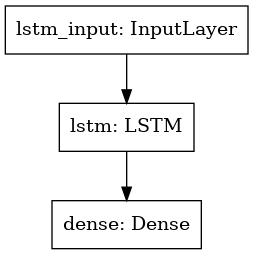

In [14]:
keras.utils.plot_model(model, to_file='vanilla-lstm.png')

### 2. Stacked LSTM

Multiple hidden LSTM layers can be stacked one on top of another in what is referred to as a Stacked LSTM model.

+ An LSTM layer requires a three-dimensional input and LSTMs by default will produce a two-dimensional output as an interpretation from the end of the sequence.

+ We can address this by having the LSTM output a value for each time step in the input data by setting the return_sequences=True argument on the layer. This allows us to have 3D output from hidden LSTM layer as input to the next.


In [18]:
# define model
model = keras.Sequential()
model.add(keras.layers.LSTM(50,
                activation='relu',
                return_sequences=True,
                input_shape=(X_train.shape[1],
                             X_train.shape[2])))

model.add(keras.layers.LSTM(50, activation='relu'))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

In [19]:
# fit model
history = model.fit(X_train, y_train, epochs=20, verbose=1)
yhat = model.predict(X_test, verbose=0)

Train on 790 samples
Epoch 1/20
790/790 [==============================] - 3s 4ms/sample - loss: 0.5524
Epoch 2/20
790/790 [==============================] - 1s 821us/sample - loss: 0.3914
Epoch 3/20
790/790 [==============================] - 1s 830us/sample - loss: 0.3684
Epoch 4/20
790/790 [==============================] - 1s 847us/sample - loss: 0.3491
Epoch 5/20
790/790 [==============================] - 1s 828us/sample - loss: 0.3319
Epoch 6/20
790/790 [==============================] - 1s 851us/sample - loss: 0.3321
Epoch 7/20
790/790 [==============================] - 1s 887us/sample - loss: 0.3250
Epoch 8/20
790/790 [==============================] - 1s 829us/sample - loss: 0.3336
Epoch 9/20
790/790 [==============================] - 1s 845us/sample - loss: 0.3207
Epoch 10/20
790/790 [==============================] - 1s 878us/sample - loss: 0.3212
Epoch 11/20
790/790 [==============================] - 1s 855us/sample - loss: 0.3182
Epoch 12/20
790/790 [=======================

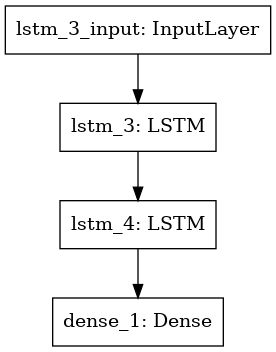

In [22]:
keras.utils.plot_model(model, to_file='stacked-lstm.png')

# Multivariate LSTM Models

Multivariate time series data means data where there is more than one observation for each time step.

There are two main models that we may require with multivariate time series data; they are:

+ Multiple Input Series.
+ Multiple Parallel Series.


### 1. Multiple Input Series

A problem may have two or more parallel input time series and an output time series that is dependent on the input time series.

The input time series are parallel because each series has an observation at the same time steps.

In [24]:
# define input sequence
in_seq1 = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = np.array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = np.array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])

In [27]:
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))

+ As with the univariate time series, we must structure these data into samples with input and output elements.

+ An LSTM model needs sufficient context to learn a mapping from an input sequence to an output value.

+ LSTMs can support parallel input time series as separate variables or features. 

+ Therefore, we need to split the data into samples maintaining the order of observations across the two input sequences.

In [59]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


array([ 25,  45,  65,  85, 105, 125, 145, 165, 185])

In [81]:
# choose a number of time steps
n_steps = 3
n_features = 2
# convert into input/output
X, y = split_sequences(dataset, n_steps)

print(X.shape, y.shape)
# summarize the data
for i in range(len(X)):
    print(X[i], y[i])

(7, 3, 2) (7,)
[[10 15]
 [20 25]
 [30 35]] 65
[[20 25]
 [30 35]
 [40 45]] 85
[[30 35]
 [40 45]
 [50 55]] 105
[[40 45]
 [50 55]
 [60 65]] 125
[[50 55]
 [60 65]
 [70 75]] 145
[[60 65]
 [70 75]
 [80 85]] 165
[[70 75]
 [80 85]
 [90 95]] 185


We can see that the X component has a three-dimensional structure.

The first dimension is the number of samples, in this case 7. The second dimension is the number of time steps per sample, in this case 3, the value specified to the function. Finally, the last dimension specifies the number of parallel time series or the number of variables, in this case 2 for the two parallel series.

In [75]:
# define model
model = keras.Sequential()
model.add(keras.layers.LSTM(50, 
               activation='relu',
               input_shape=(X.shape[1], X.shape[2])))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

In [86]:
# fit model
history = model.fit(X, y, epochs=20, verbose=1)

Train on 7 samples
Epoch 1/20
7/7 [==============================] - 0s 3ms/sample - loss: 0.0051
Epoch 2/20
7/7 [==============================] - 0s 757us/sample - loss: 0.0051
Epoch 3/20
7/7 [==============================] - 0s 657us/sample - loss: 0.0051
Epoch 4/20
7/7 [==============================] - 0s 713us/sample - loss: 0.0051
Epoch 5/20
7/7 [==============================] - 0s 791us/sample - loss: 0.0051
Epoch 6/20
7/7 [==============================] - 0s 835us/sample - loss: 0.0051
Epoch 7/20
7/7 [==============================] - 0s 1ms/sample - loss: 0.0051
Epoch 8/20
7/7 [==============================] - 0s 2ms/sample - loss: 0.0050
Epoch 9/20
7/7 [==============================] - 0s 1ms/sample - loss: 0.0050
Epoch 10/20
7/7 [==============================] - 0s 799us/sample - loss: 0.0050
Epoch 11/20
7/7 [==============================] - 0s 965us/sample - loss: 0.0050
Epoch 12/20
7/7 [==============================] - 0s 707us/sample - loss: 0.0050
Epoch 13/20
7/

In [107]:
# demonstrate prediction
x_input = np.array([[80, 85], [90, 95], [100, 105]])
x_input = x_input.reshape((1, n_steps, n_features))

x_input = x_input.astype('float32')

yhat = model.predict(x_input, verbose=1)
print(yhat)

1/1 [==============================] - 0s 7ms/sample
[[205.84683]]


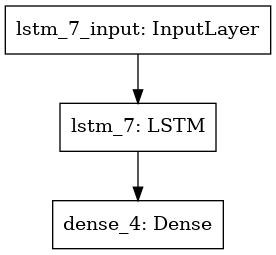

In [108]:
keras.utils.plot_model(model, to_file='stacked-lstm.png')

### 2. Multiple Parallel Series

An alternate time series problem is the case where there are multiple parallel time series and a value must be predicted for each.

---------------------------------------------

## Multi-Step LSTM Models

A time series forecasting problem that requires a prediction of multiple time steps into the future can be referred to as multi-step time series forecasting.

There are two main types of LSTM models that can be used for multi-step forecasting; they are:

+ Vector Output Model
+ Encoder-Decoder Model


#### Data Preparation

As with one-step forecasting, a time series used for multi-step time series forecasting must be split into samples with input and output components.

Both the input and output components will be comprised of multiple time steps and may or may not have the same number of steps.

In [109]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [112]:
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
print(X.shape, y.shape)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

(5, 3) (5, 2)
[10 20 30] [40 50]
[20 30 40] [50 60]
[30 40 50] [60 70]
[40 50 60] [70 80]
[50 60 70] [80 90]


## 1. Vector Output Model

Like other types of neural network models, the LSTM can output a vector directly that can be interpreted as a multi-step forecast.

In [3]:
# univariate multi-step vector-output stacked lstm example
from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=50, verbose=0)

# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps_in, n_features))

x_input = x_input.astype('float32')

yhat = model.predict(x_input, verbose=0)
print(yhat)

[[117.96977 135.9274 ]]


## 2. Encoder-Decoder Model

A model specifically developed for forecasting variable length output sequences is called the Encoder-Decoder LSTM.

The model was designed for prediction problems where there are both input and output sequences, so-called sequence-to-sequence, or seq2seq problems

As its name suggests, the model is comprised of two sub-models: the encoder and the decoder.

The encoder is a model responsible for reading and interpreting the input sequence. The output of the encoder is a fixed length vector that represents the model’s interpretation of the sequence. The encoder is traditionally a Vanilla LSTM model, although other encoder models can be used such as Stacked, Bidirectional, and CNN models.


# Multiple Input Multi-Step Output (Important)

There are those multivariate time series forecasting problems where the output series is separate but dependent upon the input time series, and multiple time steps are required for the output series.

In [10]:
# multivariate multi-step stacked lstm example
from numpy import array
from numpy import hstack
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)


In [15]:
# demonstrate prediction
x_input = array([[70, 75], [80, 85], [90, 95]])
x_input = x_input.reshape((1, n_steps_in, n_features))
x_input = x_input.astype('float32')

yhat = model.predict(x_input, verbose=0)
print(yhat)

[[187.1267  208.70033]]


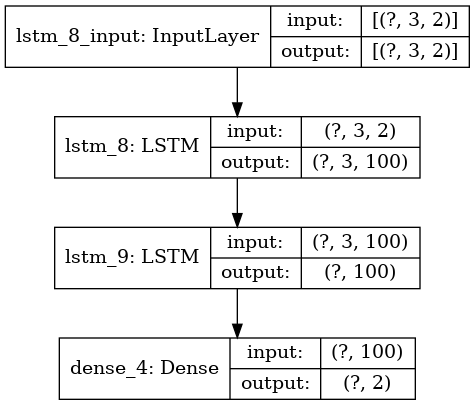

In [16]:
keras.utils.plot_model(model, show_shapes=True, to_file='multiinput-multiout-lstm.png')